### Project Description 
After the current funding programs, International Humanitarian NGO has raised around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision have mostly related to the countries in dire need of Aid. Our job is as Data analyst is to classify the countries using the socio-economic and health factors that determine the overall development of nations. After this analysis, we need to suggest countries that the CEO needs to focus on and give the highest priority.

https://www.kaggle.com/datasets/vipulgohel/clustering-pca-assignment?select=Country-data.csv

### Set Up Environment

In [1]:
import pandas as pd
import numpy as np
import sweetviz as sv
import seaborn as sns ## correlation heatmap
import matplotlib.pyplot as plt ## visual the heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly_express as px
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score


pd.set_option("display.max_columns",None)

C:\Users\tiats\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## create function

## read in data in csv
def read_data(file_name):
    df = pd.read_csv(fr"../Data/{file_name}")

    print("finishing load data...")

    display(df.info())
    display(df.head())

    return df


### Load Data & Exploratory Data Analysis(EDA)

In [3]:
## read data
df_ori = read_data("Country-data.csv")

finishing load data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


None

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



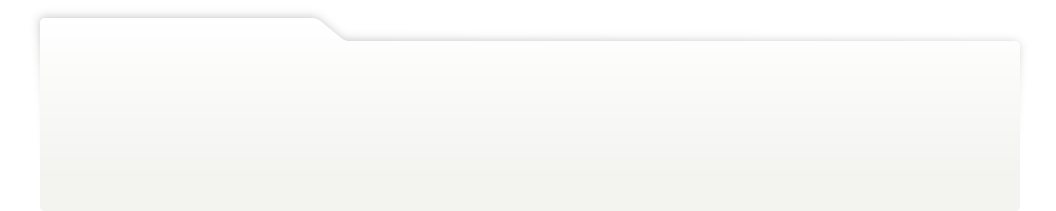
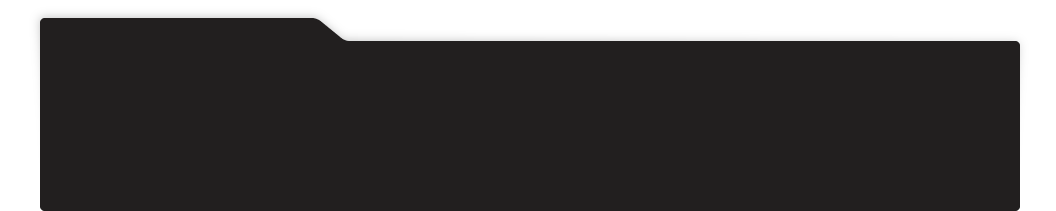
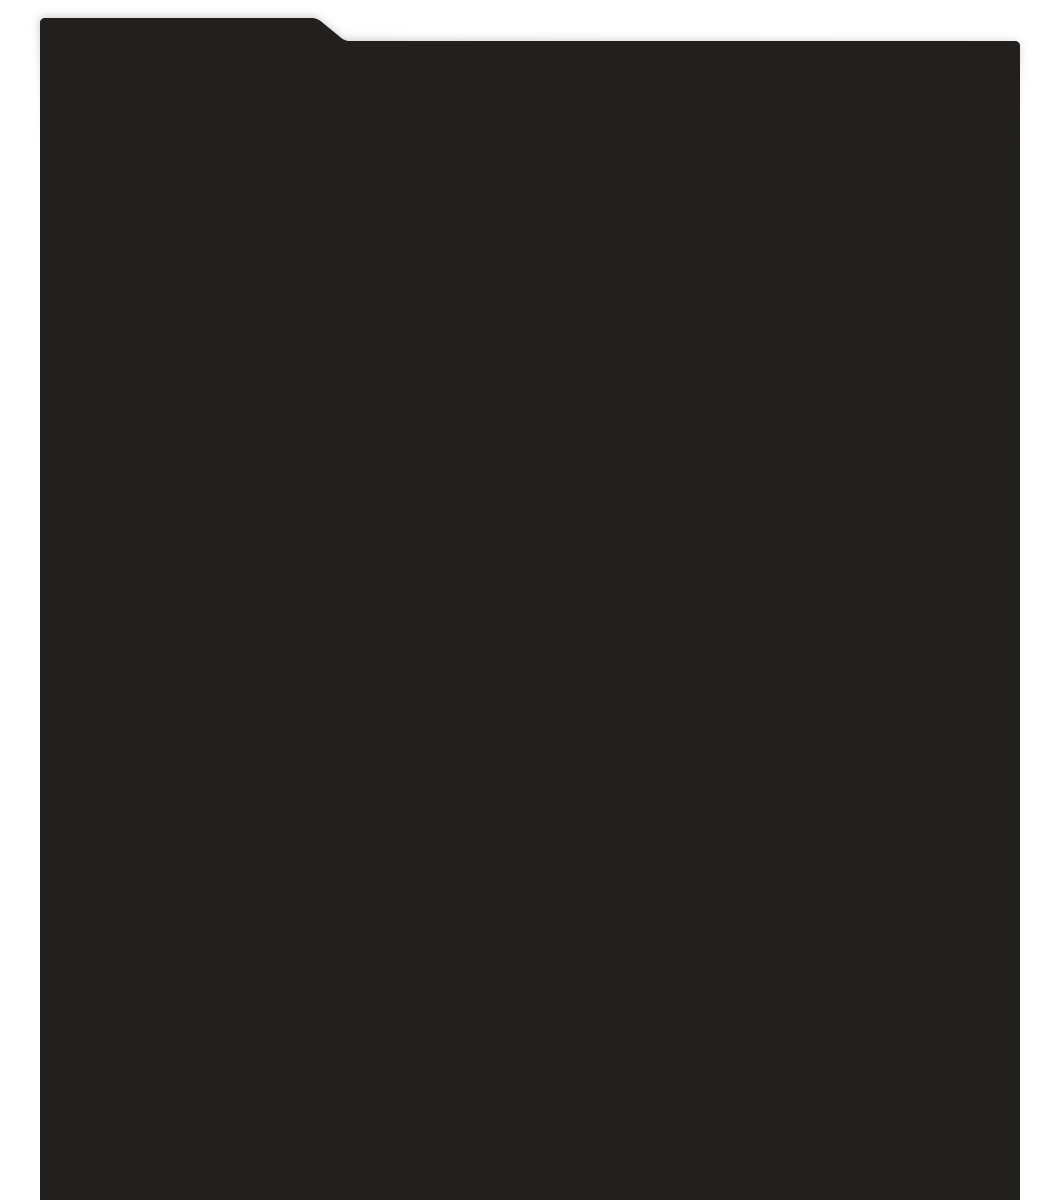
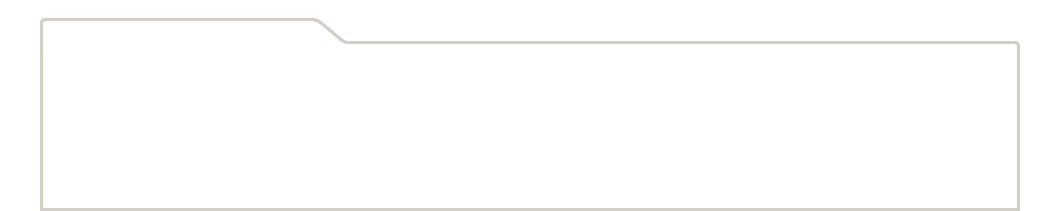
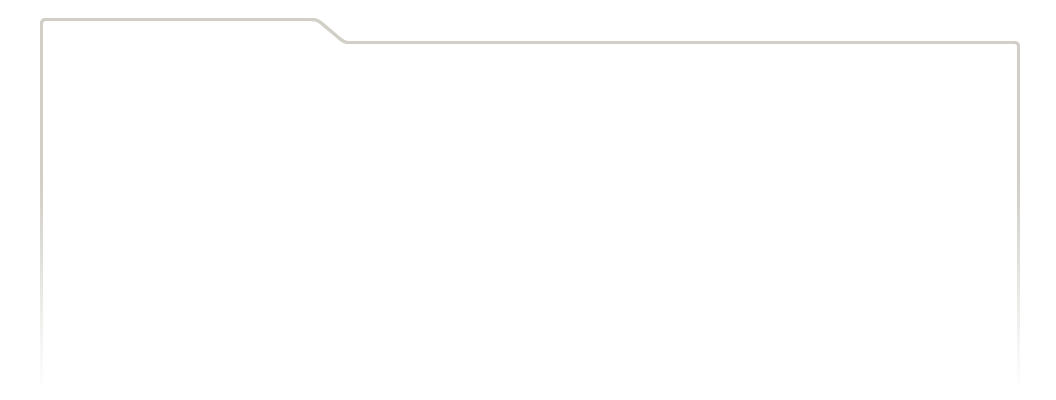
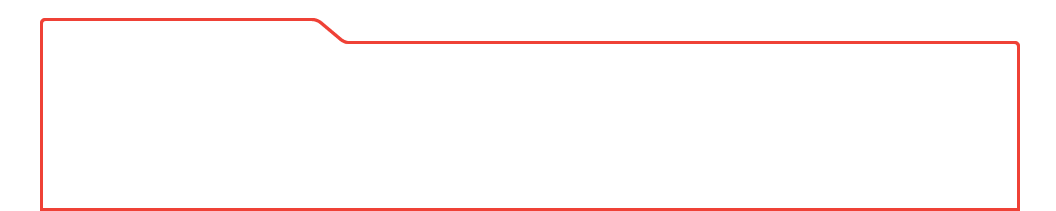
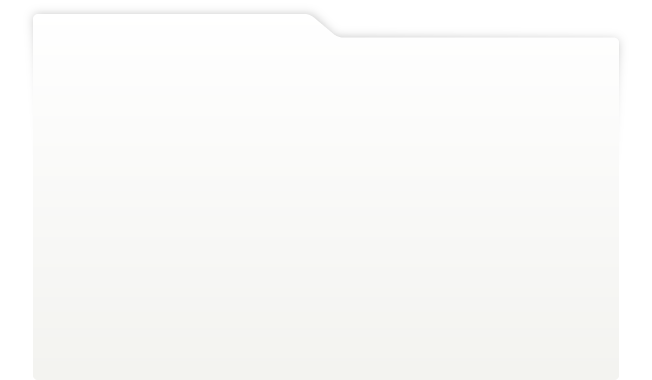
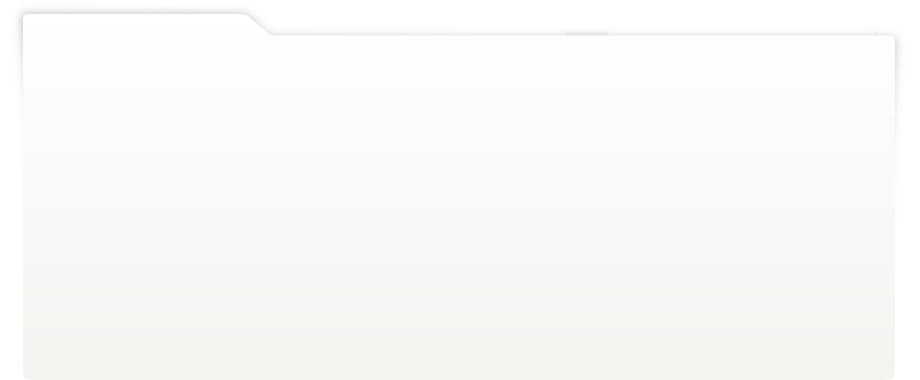
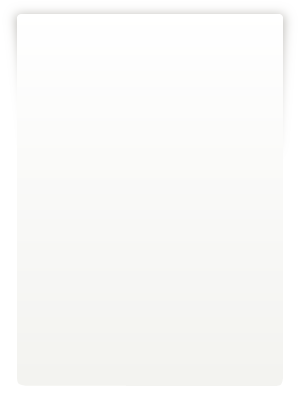
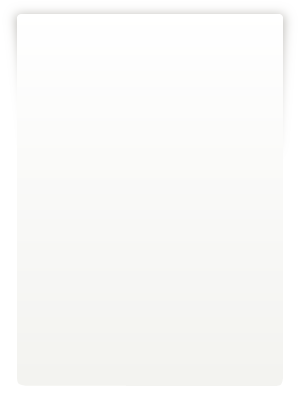
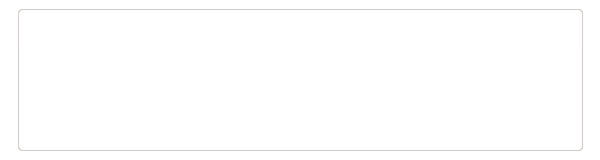
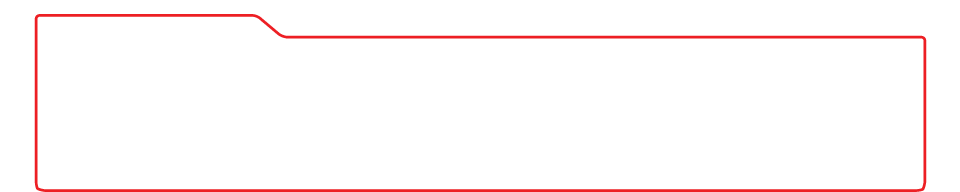
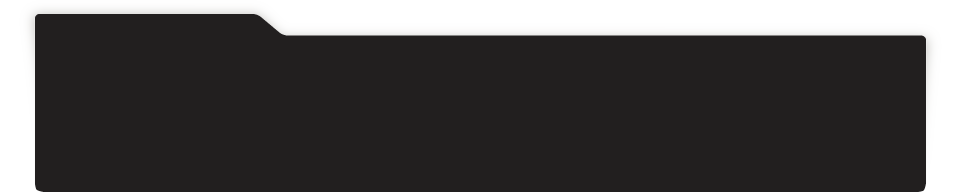
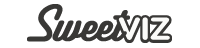
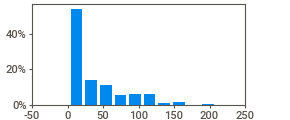
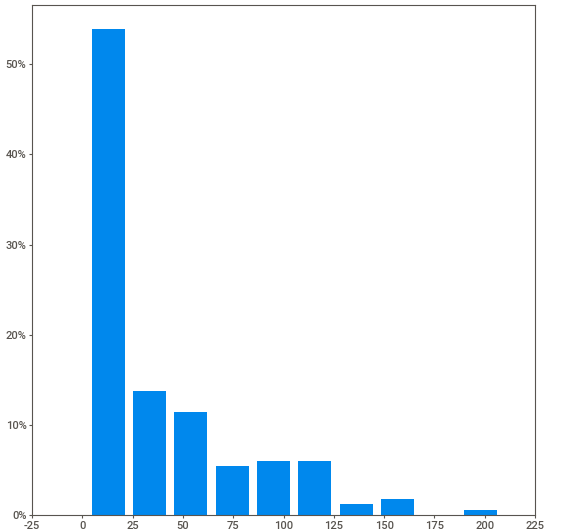
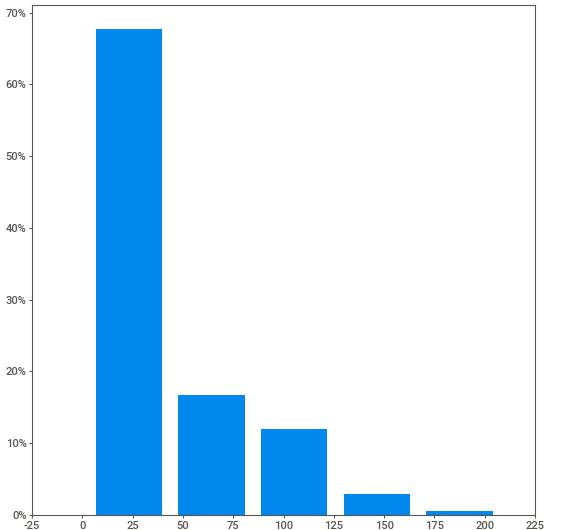
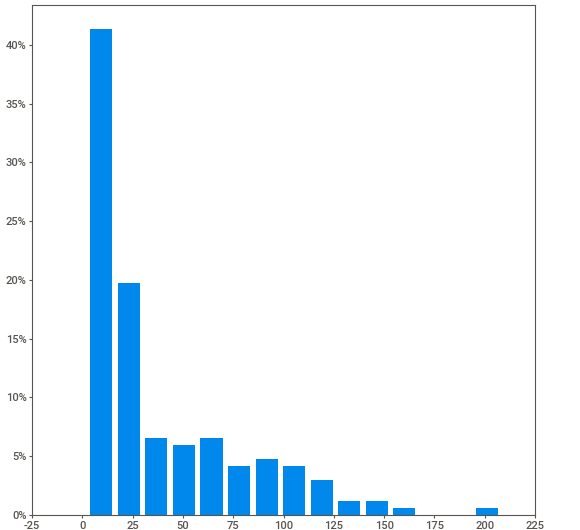
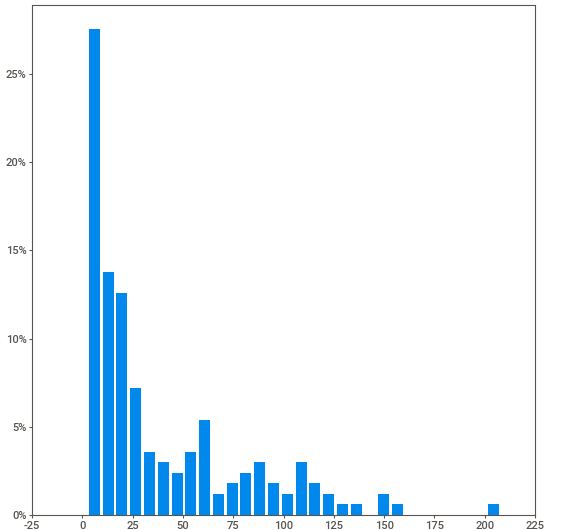
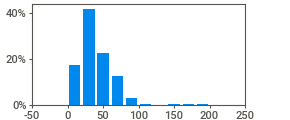
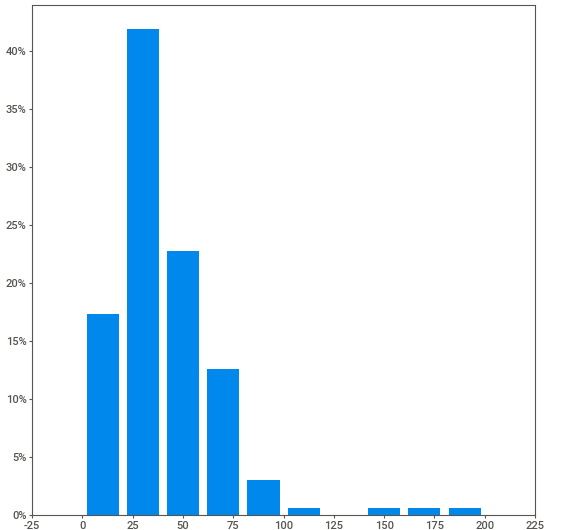
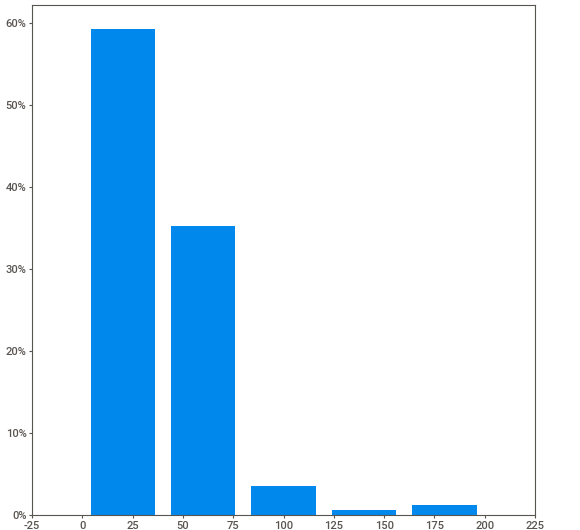
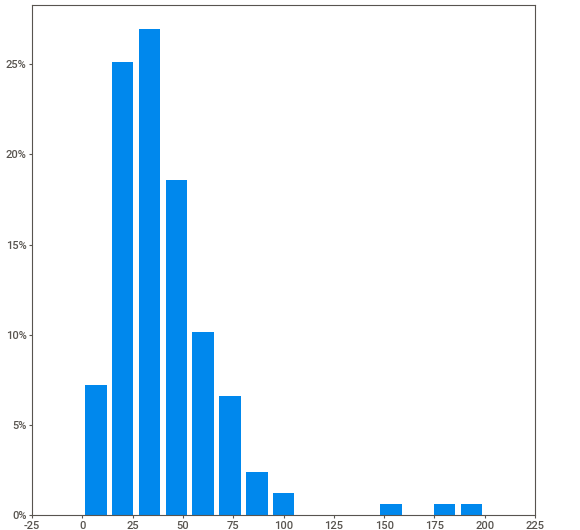
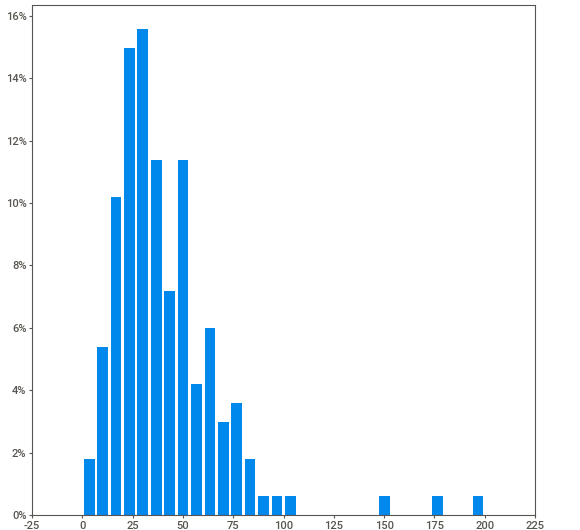
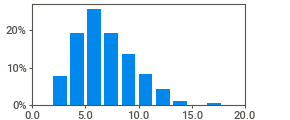
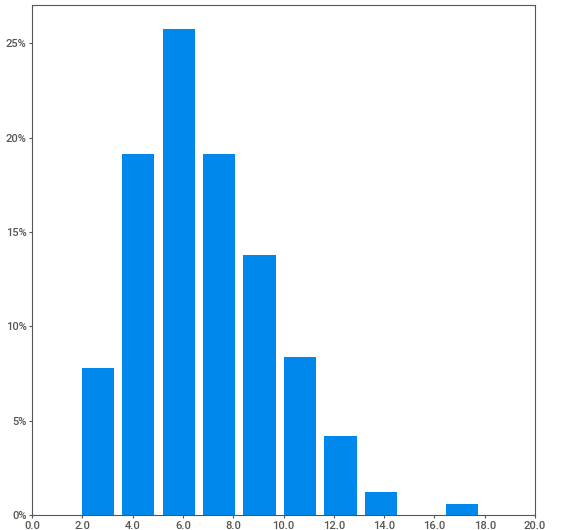
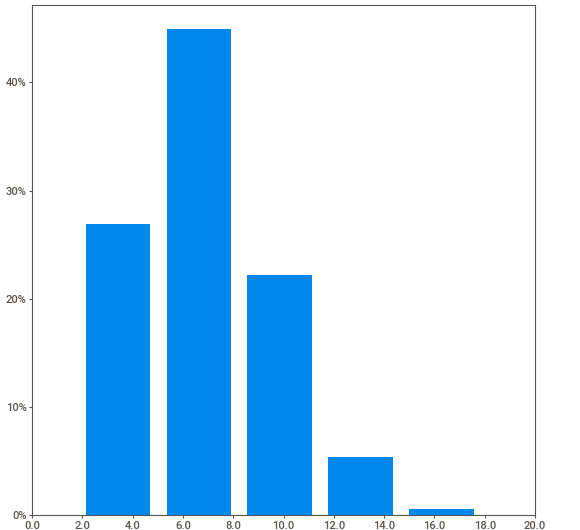
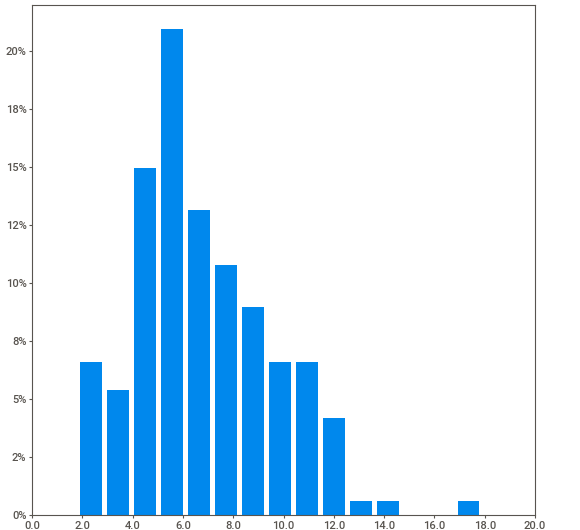
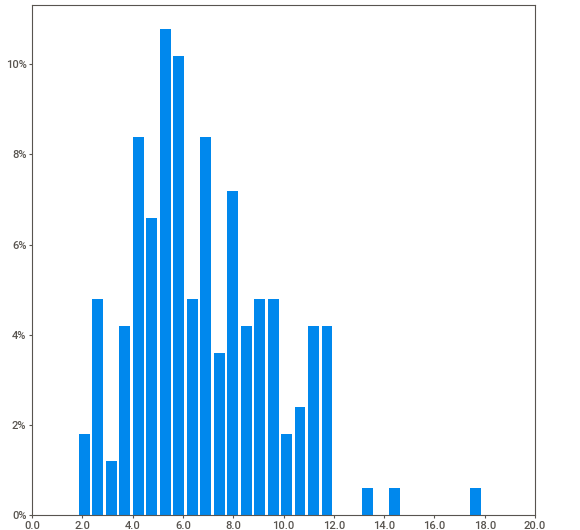
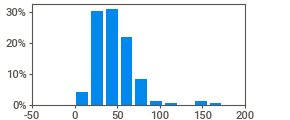
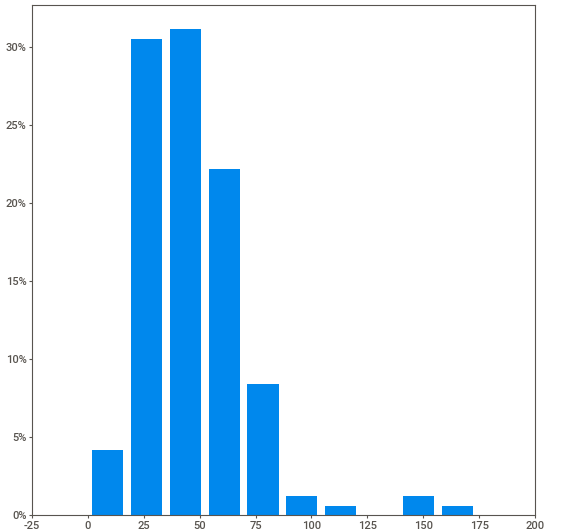
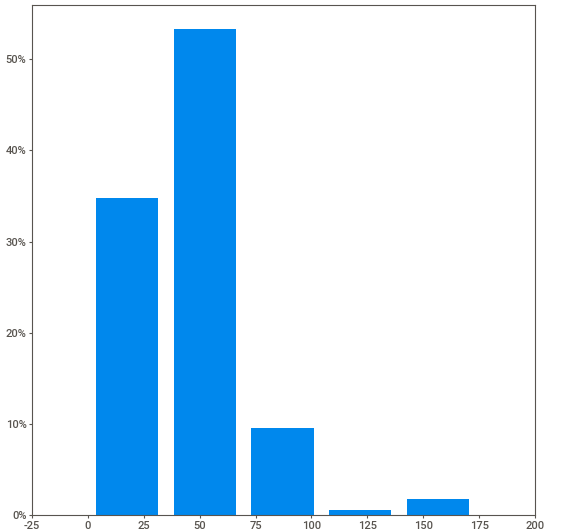
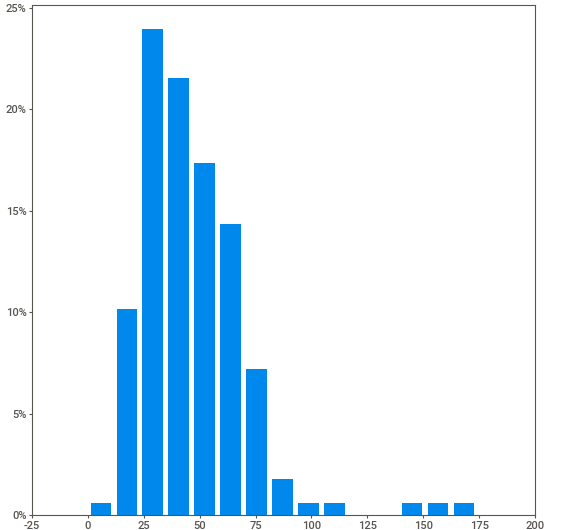
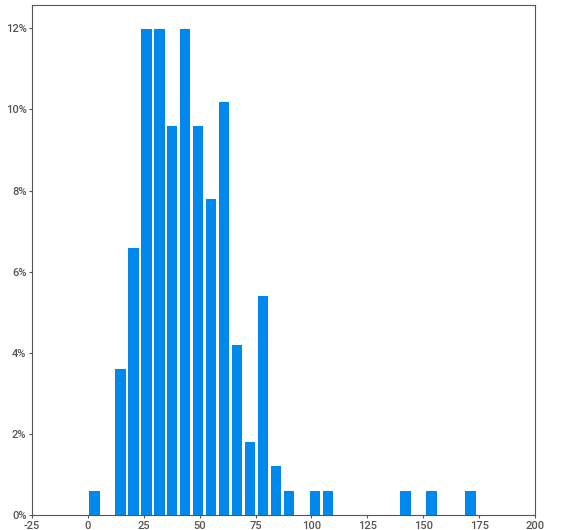
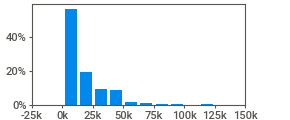
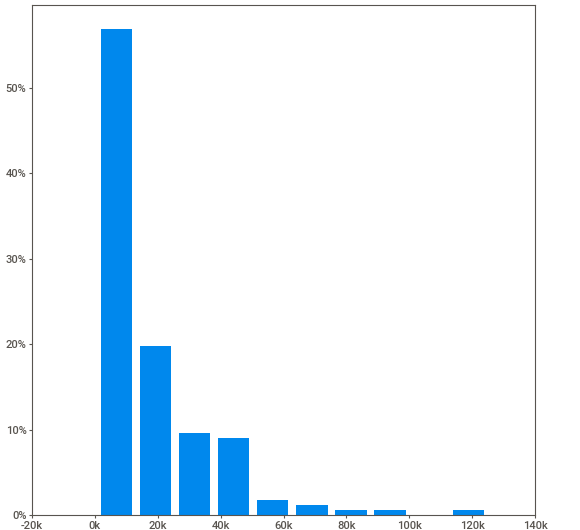
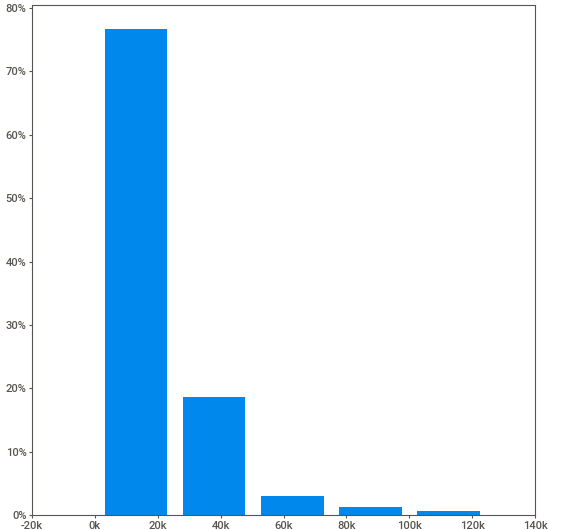
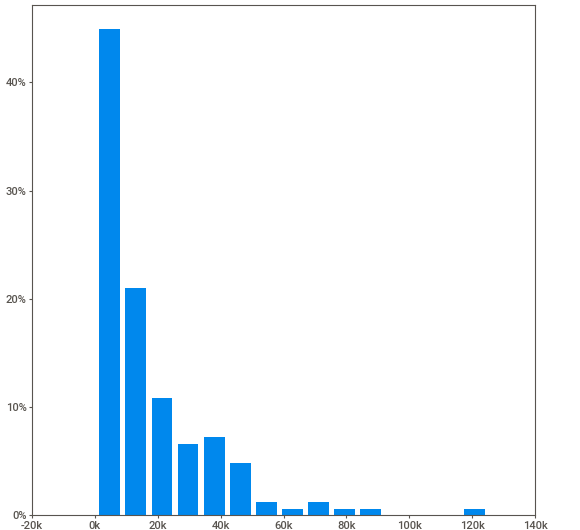
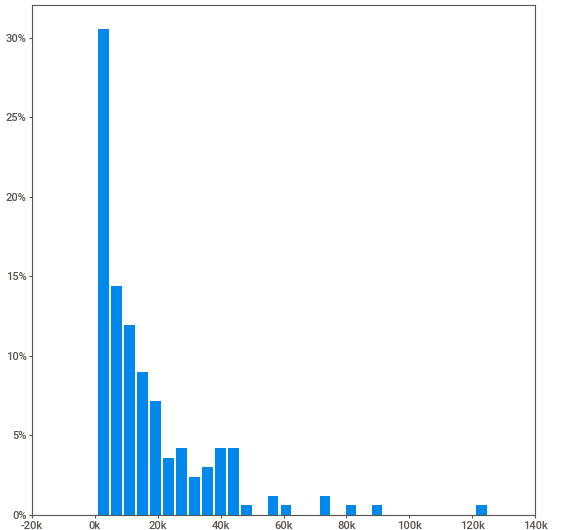
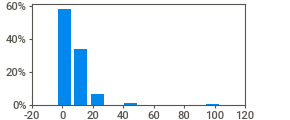
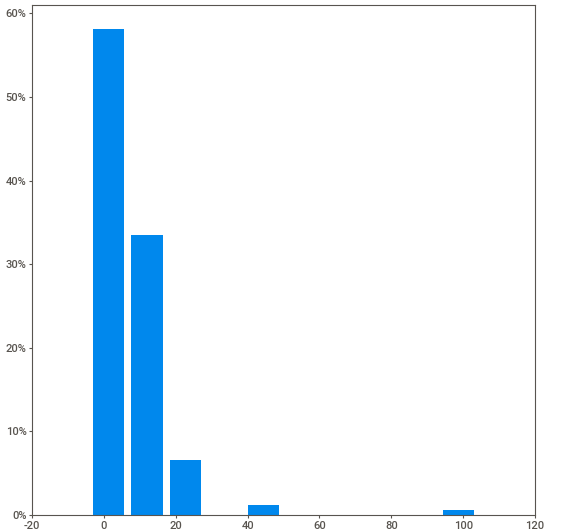
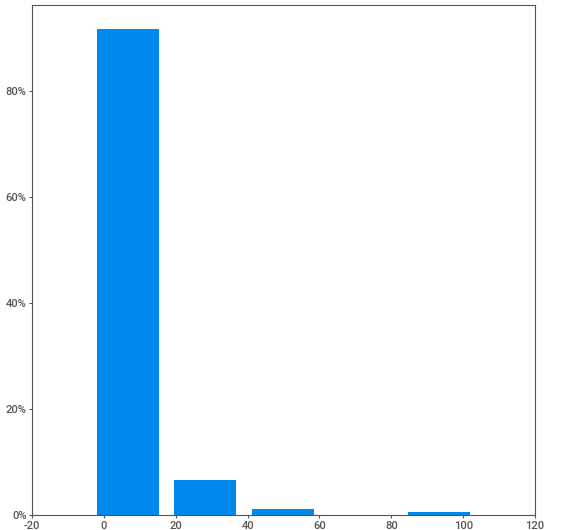
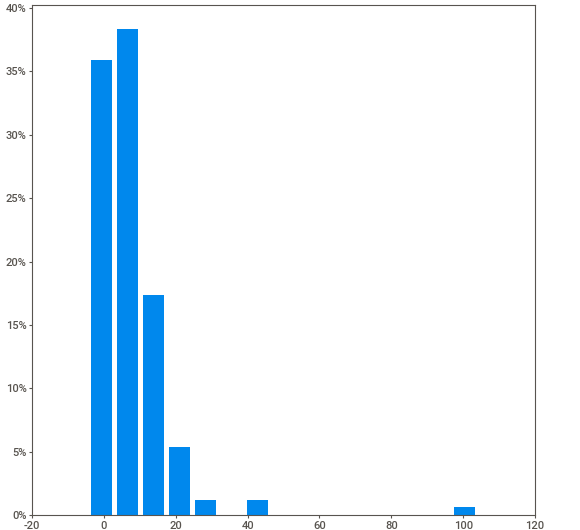
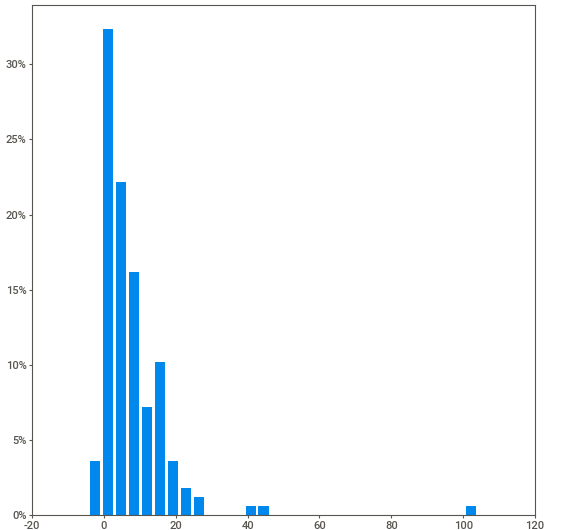
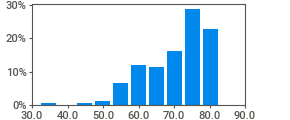
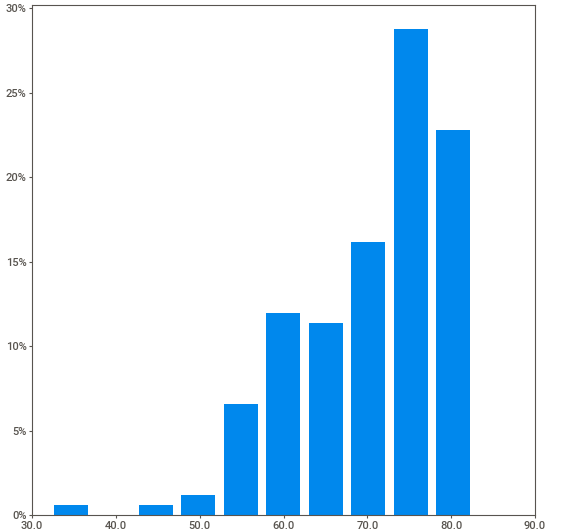
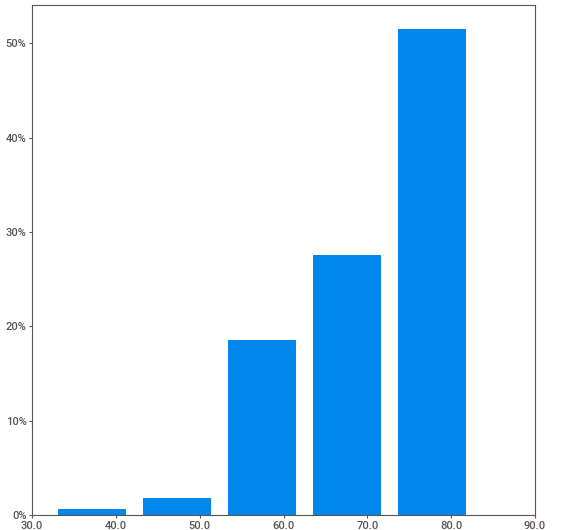
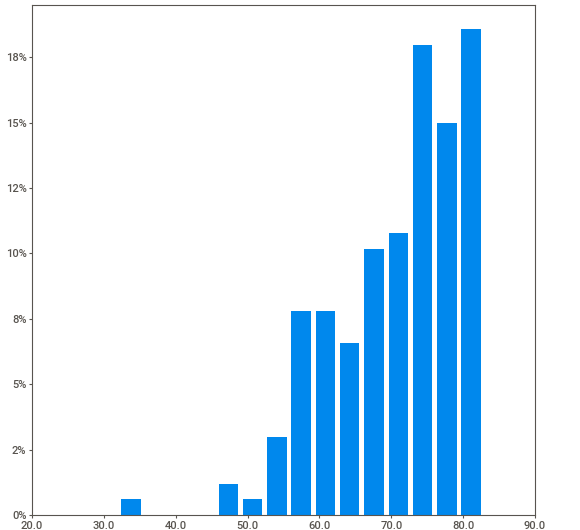
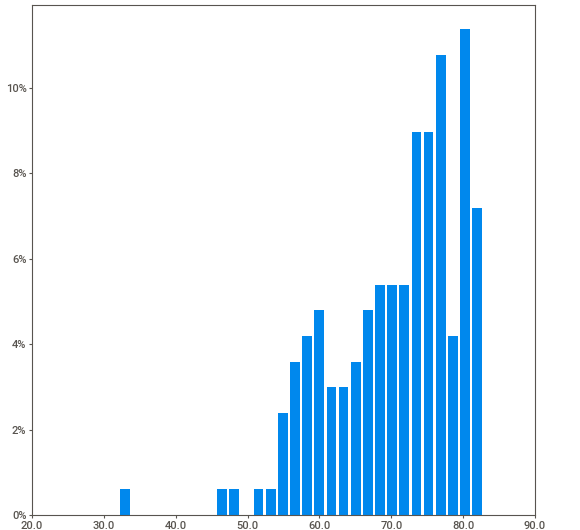
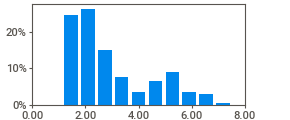
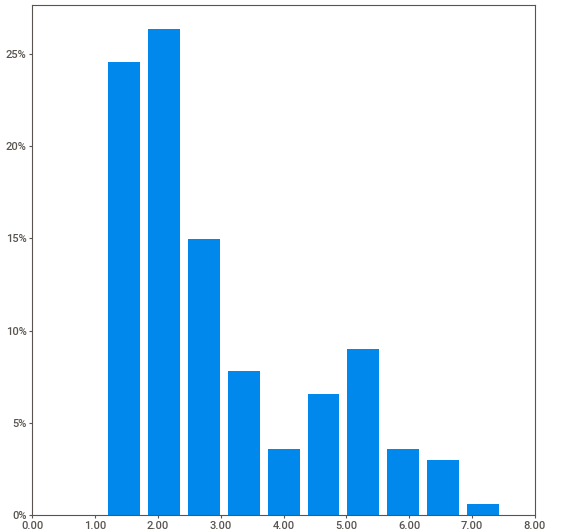
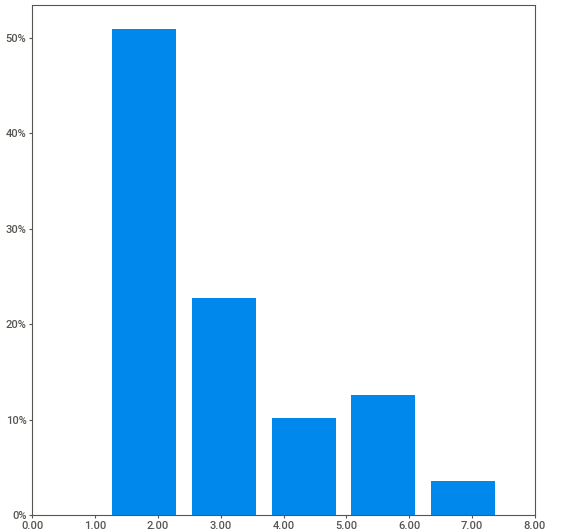
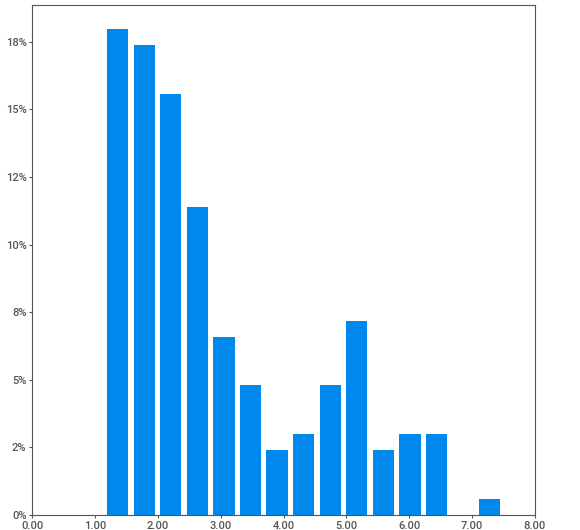
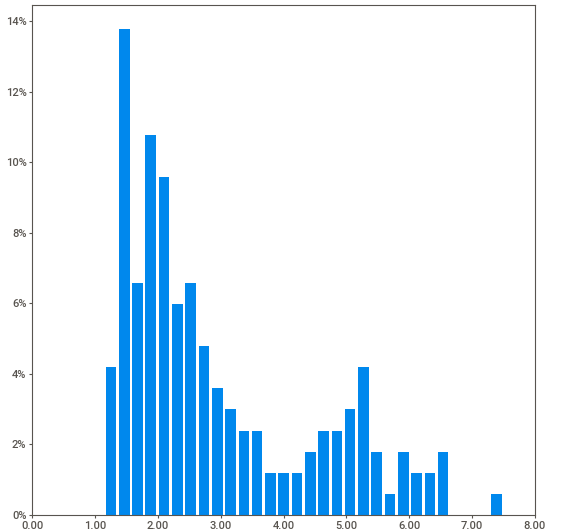
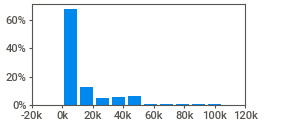
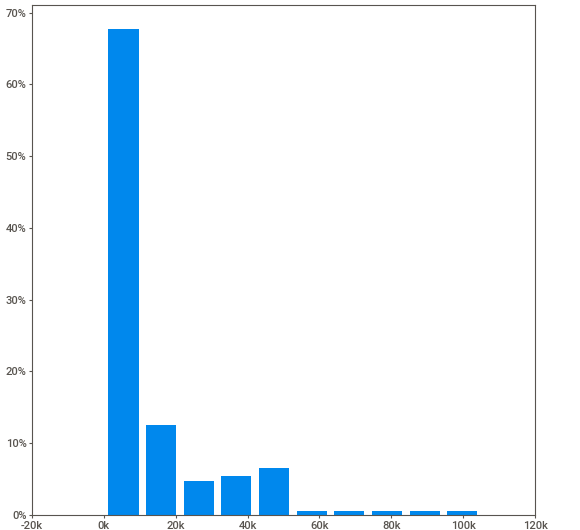
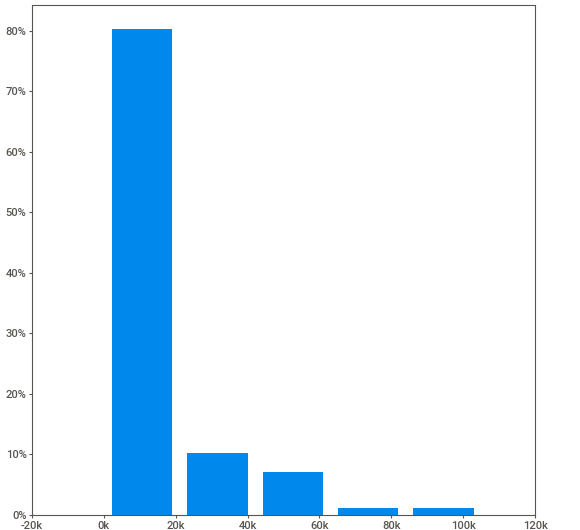
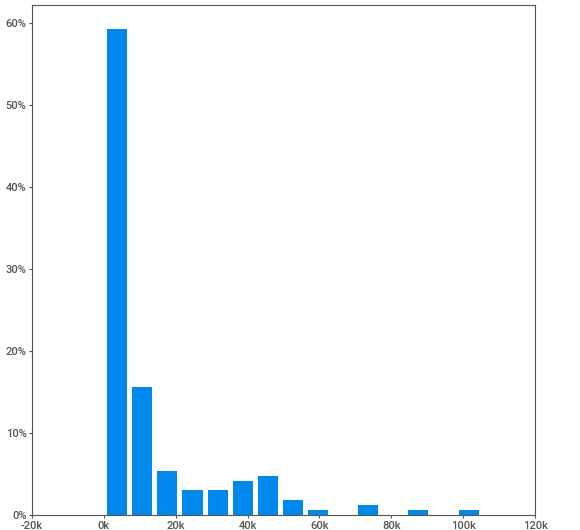
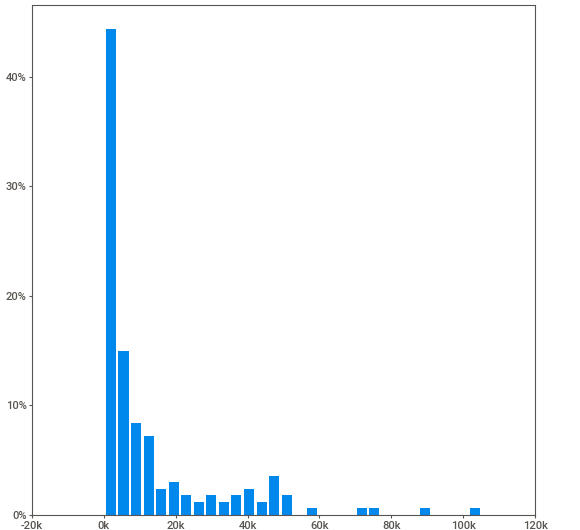
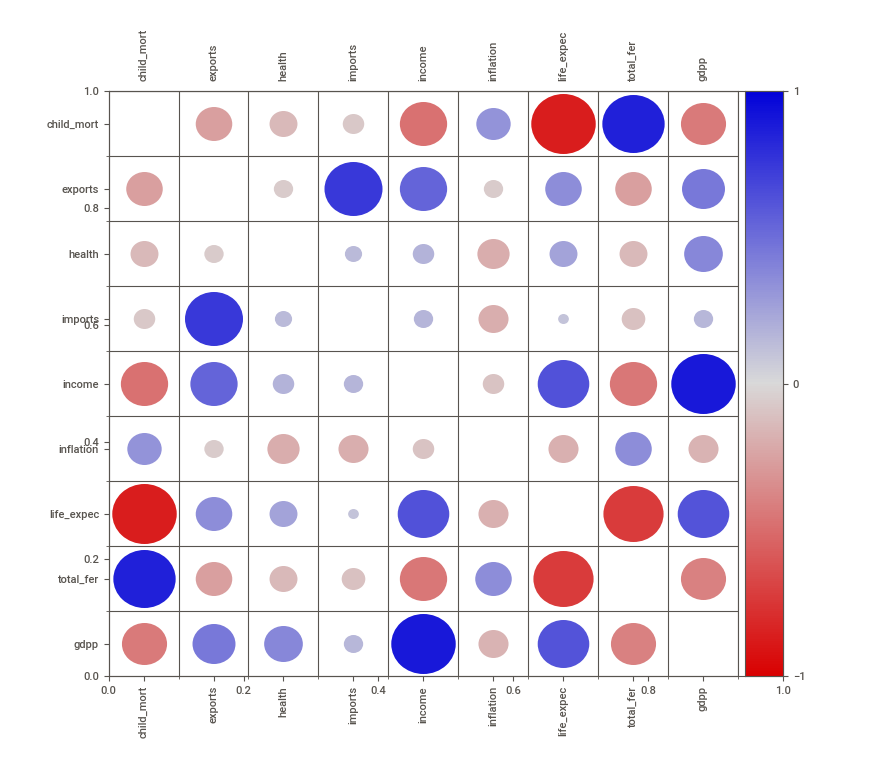
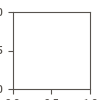

In [4]:
## EDA
report = sv.analyze(df_ori)
report.show_html('country_eda.html')
report.show_notebook()

Text(0.5, 1.0, 'Feature Correlation Heatmap')

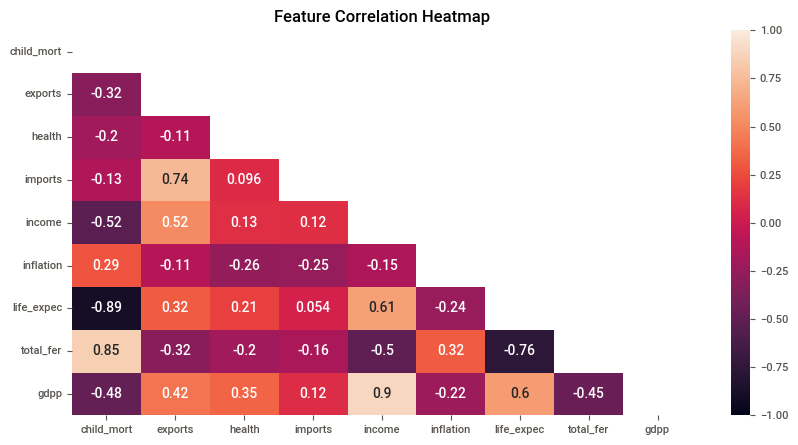

In [5]:
## better view of the correlation between features (result same as the sweetviz)
df_corr = df_ori.loc[:,df_ori.columns != 'country']
plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(df_corr.corr()))
heatmap = sns.heatmap(df_corr.corr(), vmin=-1, vmax=1, annot=True, mask=mask)
heatmap.set_title('Feature Correlation Heatmap')


based on the EDA report,
below are the extreme highly(~1) correlated variables:
* positive
    * child_mort, total_fer
    * exports, imports
    * income, gdp

* negative
    * child_mort, life_expec
    * life_expense, total_fer**

below are the highly(~0.5) correlated variables:
* positive
    * exports, income
    * income, life_expec
    * life_expec, gdp

* negative
    * child_mort, income
    * child_mort, gdp
    * income, total_fer**
    * total_fer, gdp

** interesting correlation



In [6]:
## show where are the country located
px.choropleth(df_ori,
              locations='country',
              locationmode='country names',
              template='gridon',
              title='List of Countries In Data')

### Apply PCA to Determine Features for Clustering

In [7]:
## only numerical data type are available in PCA
df_num = df_ori.drop(columns='country')
df_num

## Z-score scale the features into mean = 1 & standard deviation = 1
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

# ## apply PCA
pca = PCA()
pca.fit_transform(df_scaled)

print("show each features' importance (abs) among each component:")
display(pca.components_)
print("show the ability to expain the data by each component:")
display(pca.explained_variance_ratio_)



show each features' importance (abs) among each component:


array([[-0.41951945,  0.28389698,  0.15083782,  0.16148244,  0.39844111,
        -0.19317293,  0.42583938, -0.40372896,  0.39264482],
       [ 0.19288394,  0.61316349, -0.24308678,  0.67182064,  0.02253553,
        -0.00840447, -0.22270674,  0.15523311, -0.0460224 ],
       [-0.02954353,  0.14476069, -0.59663237, -0.29992674,  0.3015475 ,
         0.64251951,  0.11391854,  0.01954925,  0.12297749],
       [ 0.37065326,  0.00309102,  0.4618975 , -0.07190746,  0.39215904,
         0.15044176, -0.20379723,  0.37830365,  0.53199457],
       [-0.16896968,  0.05761584,  0.51800037,  0.25537642, -0.2471496 ,
         0.7148691 ,  0.1082198 , -0.13526221, -0.18016662],
       [ 0.20062815, -0.05933283,  0.00727646, -0.03003154,  0.16034699,
         0.06628537, -0.60112652, -0.75068875,  0.01677876],
       [-0.07948854, -0.70730269, -0.24983051,  0.59218953,  0.09556237,
         0.10463252,  0.01848639,  0.02882643,  0.24299776],
       [-0.68274306, -0.01419742,  0.07249683, -0.02894642,  0

show the ability to expain the data by each component:


array([0.4595174 , 0.17181626, 0.13004259, 0.11053162, 0.07340211,
       0.02484235, 0.0126043 , 0.00981282, 0.00743056])

In [8]:
## plot to show how much the component explained
fig = px.bar(x=range(pca.n_components_), y=pca.explained_variance_ratio_, title='PCA Features Explaination')
fig.update_xaxes(title_text='features')
fig.update_yaxes(title_text='variance')

fig.show()

## cumulative explanation
fig = px.line(x=range(pca.n_components_), y=np.cumsum(pca.explained_variance_ratio_), title='PCA Features Cumulative Explanation <sup><br>pick # of components between 95% - 98%</sup>')
fig.update_xaxes(title_text='features')
fig.update_yaxes(title_text='cum variance')
fig.add_hline(y=0.95, line_color='red', line_width=0.5)
fig.add_hline(y=0.98, line_color='red', line_width=0.5)

fig.show()

Based on the PCA Features Cumulative Explanation, will pick the first 5 components with 97% information in the following analysis.

In [9]:
## pick the first 5 components
pca = PCA(n_components=5)
df_pca_selected = pca.fit_transform(df_scaled)

pca.components_

array([[-0.41951945,  0.28389698,  0.15083782,  0.16148244,  0.39844111,
        -0.19317293,  0.42583938, -0.40372896,  0.39264482],
       [ 0.19288394,  0.61316349, -0.24308678,  0.67182064,  0.02253553,
        -0.00840447, -0.22270674,  0.15523311, -0.0460224 ],
       [-0.02954353,  0.14476069, -0.59663237, -0.29992674,  0.3015475 ,
         0.64251951,  0.11391854,  0.01954925,  0.12297749],
       [ 0.37065326,  0.00309102,  0.4618975 , -0.07190746,  0.39215904,
         0.15044176, -0.20379723,  0.37830365,  0.53199457],
       [-0.16896968,  0.05761584,  0.51800037,  0.25537642, -0.2471496 ,
         0.7148691 ,  0.1082198 , -0.13526221, -0.18016662]])

### Decide the K for the K-Means Clustering
- Elbow Method: 
    - calculating the Within-Cluster-Sum of Square Error(WCSS) for each num of K, choose where K starts to diminish
- Silhouette Method: 
    - range from -1 to 1, with -1 is points are assigned to wrong cluster; 0 is overlapping clusters OR points are eually close to multiple clusters; 1 is points are assigned to corrected clusters.


In [10]:
## decide the K
num_cluster = range(2,11)
wcss = []
sse = []
for i in num_cluster:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(df_pca_selected)

    wcss.append(kmeans.inertia_)
    sse.append(silhouette_score(df_pca_selected, kmeans.labels_))

## plot elbow method
fig = px.line(x=num_cluster, y=wcss, markers=True, title='Number of Clusters by Elbow Method<sup><br>4,5,6 seems to start to diminish the slope</sup>')
fig.update_xaxes(title_text='num of clusters')
fig.update_yaxes(title_text='wcss')
fig.show()
## implementing kneeLocator
kl = KneeLocator(num_cluster, wcss, curve='convex', direction='decreasing')
print(f'{kl.elbow} is the optimal cluster num based on Elbow Method')

## plot silhouette score method
fig = px.line(x=num_cluster, y=sse, markers=True, title='Number of Clusters by Silhouette Score Method <sup><br>4 has the highest Silhouette score</sup>')
fig.update_xaxes(title_text='num of clusters')
fig.update_yaxes(title_text='sse')
fig.show()


4 is the optimal cluster num based on Elbow Method


Based on aboved 2 methods, will create 4 clusters in the further analysis.

### Build the Cluster

In [11]:
cluster = KMeans(n_clusters=4, random_state=42)
cluster_model = cluster.fit_predict(df_pca_selected)
cluster_model

df_ori['cluster'] = cluster_model
df_ori


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,2
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,0
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,0
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,0
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,2


### Cluster Result & Country Priority List

In [12]:
## test the cluster result
df_ori.groupby('cluster').country.nunique()

df_result = df_ori.groupby('cluster').agg({'country':'nunique',
                               'child_mort':'mean',	
                               'exports':'mean',	
                               'health':'mean',	
                               'imports':'mean',
                               'income':'mean',
                               'inflation':'mean',
                               'life_expec':'mean',
                               'total_fer':'mean',
                               'gdpp':'mean'}).reset_index()

display(df_result.style.background_gradient())

,cluster,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,89,21.913483,41.295382,6.283483,47.918718,12969.325843,7.533607,72.693258,2.318764,6885.528090
1,1,30,4.953333,45.826667,9.168667,39.736667,45250.000000,2.742200,80.376667,1.795333,43333.333333
2,2,45,95.106667,28.602444,6.301111,42.306667,3539.844444,11.986778,59.055556,5.065333,1766.711111
3,3,3,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667


based on the metrics above, cluster 0 is medium-developed countried; cluster 1 is high-developed countries; cluster 2 is low-developed countries; cluster 3 is well-developed countries.

In [13]:
## rename the cluster
df_ori['development_type'] = np.where(df_ori['cluster']==0,'medium developed',
                                      np.where(df_ori['cluster']==1,'high developed',
                                               np.where(df_ori['cluster']==2,'low developed',
                                                        np.where(df_ori['cluster']==3,'well developed','attention'))))

df_result = df_ori.groupby('development_type').agg({'country':'nunique',
                                                    'child_mort':'mean',	
                                                    'exports':'mean',	
                                                    'health':'mean',	
                                                    'imports':'mean',
                                                    'income':'mean',
                                                    'inflation':'mean',
                                                    'life_expec':'mean',
                                                    'total_fer':'mean',
                                                    'gdpp':'mean'}).reset_index()
## color the result df for better viewing
display(df_result.style.background_gradient())

## plot it on the world map
fig = px.choropleth(df_ori,
              locations='country',
              locationmode='country names',
              template='gridon',
              color='development_type',
              title='Cluster Results')
fig.update_layout(coloraxis={'colorbar':{'dtick':1}}) ## color legend only showing integer value
fig.show()

,development_type,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,high developed,30,4.953333,45.826667,9.168667,39.736667,45250.000000,2.742200,80.376667,1.795333,43333.333333
1,low developed,45,95.106667,28.602444,6.301111,42.306667,3539.844444,11.986778,59.055556,5.065333,1766.711111
2,medium developed,89,21.913483,41.295382,6.283483,47.918718,12969.325843,7.533607,72.693258,2.318764,6885.528090
3,well developed,3,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667


based on the metrics above, \
"child_mort", "income", "inflation", "life_ecpec", "total_fer" & "gdpp" \
are extremly lower than other types of development countries.

In [14]:
## identify how to allocate the aid fundings
df_low_developed = df_ori[df_ori['development_type']=='low developed']

df_allocation = pd.DataFrame(columns=['country'])

## order by ascending 
for i in ["income", "life_expec", "gdpp"]:
    df_result = df_low_developed.sort_values(by=f'{i}')[['country',f'{i}']].reset_index(drop=True).head(15)
    df_allocation = pd.merge(df_allocation, df_result, on='country', how='outer')
## order by descending
for i in ["child_mort", "inflation", "total_fer"]:
    df_result = df_low_developed.sort_values(by=f'{i}', ascending=False)[['country',f'{i}']].reset_index(drop=True).head(15)
    df_allocation = pd.merge(df_allocation, df_result, on='country', how='outer')

df_allocation['times_of_top'] = df_allocation.notna().sum(axis=1)-1
df_allocation.sort_values(by='times_of_top', ascending=False, ignore_index=True).head(15)

,country,income,life_expec,gdpp,child_mort,inflation,total_fer,times_of_top
0,"Congo, Dem. Rep.",609.0,57.5,334.0,116.0,20.8,6.54,6
1,Sierra Leone,1220.0,55.0,399.0,160.0,17.2,NaN,5
2,Guinea-Bissau,1390.0,55.6,547.0,114.0,NaN,NaN,4
3,Burundi,764.0,NaN,231.0,NaN,12.3,6.26,4
4,Niger,814.0,NaN,348.0,123.0,NaN,7.49,4
5,Central African Republic,888.0,47.5,446.0,149.0,NaN,NaN,4
6,Mozambique,918.0,54.5,419.0,NaN,NaN,5.56,4
7,Angola,NaN,NaN,NaN,119.0,22.4,6.16,3
8,Nigeria,NaN,NaN,NaN,130.0,104.0,5.84,3
9,Chad,NaN,56.5,NaN,150.0,NaN,6.59,3


Based on above 6 KPIs which are hugely different from the other development clusters, here are the top 7 countries by priority reconmmended for the aid funding:
1. Congo, Dem. Rep.
2. Sierra Leone
3. Guinea-Bissau	
4. Burundi	
5. Niger
6. Central African Republic	
7. Mozambique	
\
...
rest of the list will be using the same logic 

